In [1]:
import pandas as pd
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/amalsn/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/amalsn/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/amalsn/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/amalsn/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/amalsn/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[n

True

# 1. Loading and Preprocessing FakeNewsNet Dataset


In [5]:
# Load FakeNewsNet dataset

#!unzip FakeNewsNet-master.zip

df_politifact_fake = pd.read_csv("politifact_fake.csv")
df_politifact_real = pd.read_csv("politifact_real.csv")
df_gossipcop_fake  = pd.read_csv("gossipcop_fake.csv")
df_gossipcop_real  = pd.read_csv("gossipcop_real.csv")

print("Politifact Fake shape:", df_politifact_fake.shape)
print("Politifact Real shape:", df_politifact_real.shape)
print("GossipCop Fake shape:", df_gossipcop_fake.shape)
print("GossipCop Real shape:", df_gossipcop_real.shape)



Politifact Fake shape: (432, 4)
Politifact Real shape: (624, 4)
GossipCop Fake shape: (5323, 4)
GossipCop Real shape: (16817, 4)


In [6]:
# Display dataset sample
print(df_politifact_fake.head())
print(df_politifact_real.head())
print(df_gossipcop_fake.head())
print(df_gossipcop_real.head())


                id                                           news_url  \
0  politifact15014          speedtalk.com/forum/viewtopic.php?t=51650   
1  politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
2  politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
3  politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
4  politifact15371  http://washingtonsources.org/trump-votes-for-d...   

                                               title  \
0  BREAKING: First NFL Team Declares Bankruptcy O...   
1  Court Orders Obama To Pay $400 Million In Rest...   
2  UPDATE: Second Roy Moore Accuser Works For Mic...   
3         Oscar Pistorius Attempts To Commit Suicide   
4        Trump Votes For Death Penalty For Being Gay   

                                           tweet_ids  
0  937349434668498944\t937379378006282240\t937380...  
1  972666281441878016\t972678396575559680\t972827...  
2  929405740732870656\t929439450400264192\t929439...  
3  8

In [7]:
df_politifact_fake['label'] = 0
df_politifact_real['label'] = 1
df_gossipcop_fake['label'] = 0
df_gossipcop_real['label'] = 1

# Concatenate them all
fakenews_df = pd.concat([
    df_politifact_fake,
    df_politifact_real,
    df_gossipcop_fake,
    df_gossipcop_real
], ignore_index=True)

print("Combined FakeNewsNet shape:", fakenews_df.shape)


Combined FakeNewsNet shape: (23196, 5)


In [8]:
fakenews_df.head()


,id,news_url,title,tweet_ids,label
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0


In [9]:
fakenews_df['title'] = fakenews_df['title'].fillna("")

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation or special characters
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 6. Rejoin tokens
    cleaned_text = " ".join(tokens)
    return cleaned_text


In [10]:
print(fakenews_df.columns)


Index(['id', 'news_url', 'title', 'tweet_ids', 'label'], dtype='object')


In [11]:
fakenews_df['title'] = fakenews_df['title'].fillna('')

# Create a new column with the cleaned text
fakenews_df['clean_title'] = fakenews_df['title'].apply(preprocess_text)

fakenews_df[['title', 'clean_title', 'label']].head()


,title,clean_title,label
0,BREAKING: First NFL Team Declares Bankruptcy O...,breaking first nfl team declares bankruptcy kn...,0
1,Court Orders Obama To Pay $400 Million In Rest...,court order obama pay 400 million restitution,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,update second roy moore accuser work michelle ...,0
3,Oscar Pistorius Attempts To Commit Suicide,oscar pistorius attempt commit suicide,0
4,Trump Votes For Death Penalty For Being Gay,trump vote death penalty gay,0


In [12]:
fakenews_df.to_csv("cleaned_fakenews_df.csv", index=False)
print("\nSaved cleaned fakenews dataset to 'cleaned_fakenews_df.csv'.")


Saved cleaned fakenews dataset to 'cleaned_fakenews_df.csv'.


# 2. Loading and Preprocessing LIAR Dataset

In [13]:
# Load LIAR dataset

# !unzip liar_dataset.zip

liar_columns = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"
]

liar_train = pd.read_csv("train.tsv", sep='\t', names=liar_columns, header=None)
liar_test = pd.read_csv("test.tsv", sep='\t', names=liar_columns, header=None)
liar_valid = pd.read_csv("valid.tsv", sep= '\t', names=liar_columns, header = None)


print("liar train shape:", liar_train.shape)
print("liar test shape:", liar_test.shape)
print( "liar valid shape:", liar_valid.shape)


liar train shape: (10240, 14)
liar test shape: (1267, 14)
liar valid shape: (1284, 14)


In [14]:
# Display dataset sample
print(liar_train.head())
print(liar_test.head())

           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true  

In [15]:
# Fill missing statement/context with empty strings
for col in ["statement", "context", "subject", "party", "speaker"]:
    liar_train[col] = liar_train[col].fillna("")

# Map textual labels to binary: 1 = (true, mostly-true, half-true), 0 = (barely-true, false, pants-fire)
label_mapping = {
    "true": 1,
    "mostly-true": 1,
    "half-true": 1,
    "barely-true": 0,
    "false": 0,
    "pants-fire": 0
}

liar_train['label'] = liar_train['label'].map(label_mapping)


In [16]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()

    # 2. Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [17]:
# Apply to "statement" and "context"
liar_train['clean_statement'] = liar_train['statement'].apply(preprocess_text)
liar_train['clean_context']   = liar_train['context'].apply(preprocess_text)



In [18]:
from sklearn.preprocessing import LabelEncoder

# ENCODE CATEGORICALS

# 1) One-hot encode "party"
liar_train = pd.get_dummies(liar_train, columns=['party'], drop_first=True)

# 2) Label-encode "speaker" (turn speaker names into numeric IDs)
encoder = LabelEncoder()
liar_train['speaker'] = encoder.fit_transform(liar_train['speaker'].astype(str))

# TF-IDF FOR "subject"
vectorizer = TfidfVectorizer()
subject_tfidf = vectorizer.fit_transform(liar_train['subject'])


print("LIAR dataset shape:", liar_train.shape)
print(liar_train.head(5))



LIAR dataset shape: (10240, 38)
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      1  When did the decline of coal start? It started...   
2    324.json      1  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json      0  Health care reform legislation is likely to ma...   
4   9028.json      1  The economic turnaround started at the end of ...   

                              subject  speaker             job_title  \
0                            abortion      815  State representative   
1  energy,history,job-accomplishments     2492        State delegate   
2                      foreign-policy      183             President   
3                         health-care      273                   NaN   
4                        economy,jobs      429                   NaN   

      state  barely_true  false  half_true  ...  party_liberal-party-canada  \
0    

In [19]:
liar_train.to_csv("cleaned_liar_dataset.csv", index=False)
print("\nSaved cleaned LIAR dataset to 'cleaned_liar_dataset.csv'.")


Saved cleaned LIAR dataset to 'cleaned_liar_dataset.csv'.


# 3. Train-Test Split

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#For FakeNews
# Load cleaned datasets
fakenews_df = pd.read_csv("cleaned_fakenews_df.csv")
liar_train = pd.read_csv("cleaned_liar_dataset.csv")

# Ensure there are no NaN values in text columns
fakenews_df['clean_title'] = fakenews_df['clean_title'].fillna('')
liar_train['clean_statement'] = liar_train['clean_statement'].fillna('')
liar_train['clean_context'] = liar_train['clean_context'].fillna('')

# ------------------- Baseline Model for FakeNewsNet ------------------- #
# Feature Extraction (TF-IDF on clean_title)
vectorizer = TfidfVectorizer()
X_fakenews = vectorizer.fit_transform(fakenews_df['clean_title'])
y_fakenews = fakenews_df['label']

# Train-Test Split
X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(X_fakenews, y_fakenews, test_size=0.2, random_state=42)

#For LIAR

vectorizer_statement = TfidfVectorizer()
vectorizer_context = TfidfVectorizer()
X_liar_statement = vectorizer_statement.fit_transform(liar_train['clean_statement'])
X_liar_context = vectorizer_context.fit_transform(liar_train['clean_context'])
X_liar = hstack([X_liar_statement, X_liar_context])
y_liar = liar_train['label']

# Train-Test Split
X_train_liar, X_test_liar, y_train_liar, y_test_liar = train_test_split(X_liar, y_liar, test_size=0.2, random_state=42)

# 4. Baseline and Deep Learning Model Implementations

In [83]:
## LOGISTIC REGRESSION MODEL ##
# FakeNews
lr_model1 = LogisticRegression()
lr_model1.fit(X_train_fake, y_train_fake)
y_pred_lr1 = lr_model1.predict(X_test_fake)
print("Logistic Regression Accuracy (FakeNewsNet):", accuracy_score(y_test_fake, y_pred_lr1))
print(classification_report(y_test_fake, y_pred_lr1))

#LIAR

lr_model2 = LogisticRegression()
lr_model2.fit(X_train_liar, y_train_liar)
y_pred_lr2 = lr_model2.predict(X_test_liar)
print("Logistic Regression Accuracy (LIAR Dataset):", accuracy_score(y_test_liar, y_pred_lr2))
print(classification_report(y_test_liar, y_pred_lr2))

Logistic Regression Accuracy (FakeNewsNet): 0.8387931034482758
              precision    recall  f1-score   support

           0       0.82      0.46      0.59      1166
           1       0.84      0.97      0.90      3474

    accuracy                           0.84      4640
   macro avg       0.83      0.71      0.74      4640
weighted avg       0.84      0.84      0.82      4640

Logistic Regression Accuracy (LIAR Dataset): 0.609375
              precision    recall  f1-score   support

           0       0.56      0.44      0.50       888
           1       0.63      0.74      0.68      1160

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.59      2048
weighted avg       0.60      0.61      0.60      2048



In [72]:
# Naïve Bayes Model

#FakeNews
nb_model1 = MultinomialNB()
nb_model1.fit(X_train_fake, y_train_fake)
y_pred_nb1 = nb_model1.predict(X_test_fake)
print("Naive Bayes Accuracy (FakeNewsNet):", accuracy_score(y_test_fake, y_pred_nb1))
print(classification_report(y_test_fake, y_pred_nb1))

#LIAR
nb_model2 = MultinomialNB()
nb_model2.fit(X_train_liar, y_train_liar)
y_pred_nb2 = nb_model2.predict(X_test_liar)
print("Naive Bayes Accuracy (LIAR Dataset):", accuracy_score(y_test_liar, y_pred_nb2))
print(classification_report(y_test_liar, y_pred_nb2))

Naive Bayes Accuracy (FakeNewsNet): 0.8181034482758621
              precision    recall  f1-score   support

           0       0.88      0.32      0.47      1166
           1       0.81      0.98      0.89      3474

    accuracy                           0.82      4640
   macro avg       0.84      0.65      0.68      4640
weighted avg       0.83      0.82      0.78      4640

Naive Bayes Accuracy (LIAR Dataset): 0.61376953125
              precision    recall  f1-score   support

           0       0.60      0.33      0.43       888
           1       0.62      0.83      0.71      1160

    accuracy                           0.61      2048
   macro avg       0.61      0.58      0.57      2048
weighted avg       0.61      0.61      0.59      2048



In [101]:
# Support Vector machine

#FakeNews
svm_model1 = svm.SVC()
svm_model1.fit(X_train_fake, y_train_fake)
y_pred_svm1 = svm_model1.predict(X_test_fake)
print("Fully Connected network Accuracy (FakeNewsNet):", accuracy_score(y_test_fake, y_pred_svm1))
print(classification_report(y_test_fake, y_pred_svm1))

#LIAR
svm_model2 = svm.SVC()
svm_model2.fit(X_train_liar, y_train_liar)
y_pred_svm2 = svm_model2.predict(X_test_liar)
print("Fully Connected network Accuracy (LIAR):", accuracy_score(y_test_liar, y_pred_svm2))
print(classification_report(y_test_liar, y_pred_svm2))

Fully Connected network Accuracy (FakeNewsNet): 0.8422413793103448
              precision    recall  f1-score   support

           0       0.83      0.47      0.60      1166
           1       0.84      0.97      0.90      3474

    accuracy                           0.84      4640
   macro avg       0.84      0.72      0.75      4640
weighted avg       0.84      0.84      0.83      4640

Fully Connected network Accuracy (LIAR): 0.61572265625
              precision    recall  f1-score   support

           0       0.59      0.36      0.45       888
           1       0.62      0.81      0.71      1160

    accuracy                           0.62      2048
   macro avg       0.61      0.59      0.58      2048
weighted avg       0.61      0.62      0.59      2048



In [104]:
# Fully Connected model

#FakeNews
fc_model1 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(64, 16), random_state=1, max_iter=1000)
fc_model1.fit(X_train_fake, y_train_fake)
y_pred_fc1 = fc_model1.predict(X_test_fake)
print("Fully Connected network Accuracy (FakeNewsNet):", accuracy_score(y_test_fake, y_pred_fc1))
print(classification_report(y_test_fake, y_pred_fc1))

#LIAR
fc_model2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,16), random_state=1, max_iter=1000)
fc_model2.fit(X_train_liar, y_train_liar)
y_pred_fc2 = fc_model2.predict(X_test_liar)
print("Fully Connected network Accuracy (LIAR):", accuracy_score(y_test_liar, y_pred_fc2))
print(classification_report(y_test_liar, y_pred_fc2, zero_division=0))

/home/amalsn/anaconda3/envs/asn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Fully Connected network Accuracy (FakeNewsNet): 0.8174568965517242
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1166
           1       0.87      0.88      0.88      3474

    accuracy                           0.82      4640
   macro avg       0.76      0.75      0.75      4640
weighted avg       0.82      0.82      0.82      4640

Fully Connected network Accuracy (LIAR): 0.56298828125
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       888
           1       0.61      0.62      0.62      1160

    accuracy                           0.56      2048
   macro avg       0.55      0.55      0.55      2048
weighted avg       0.56      0.56      0.56      2048



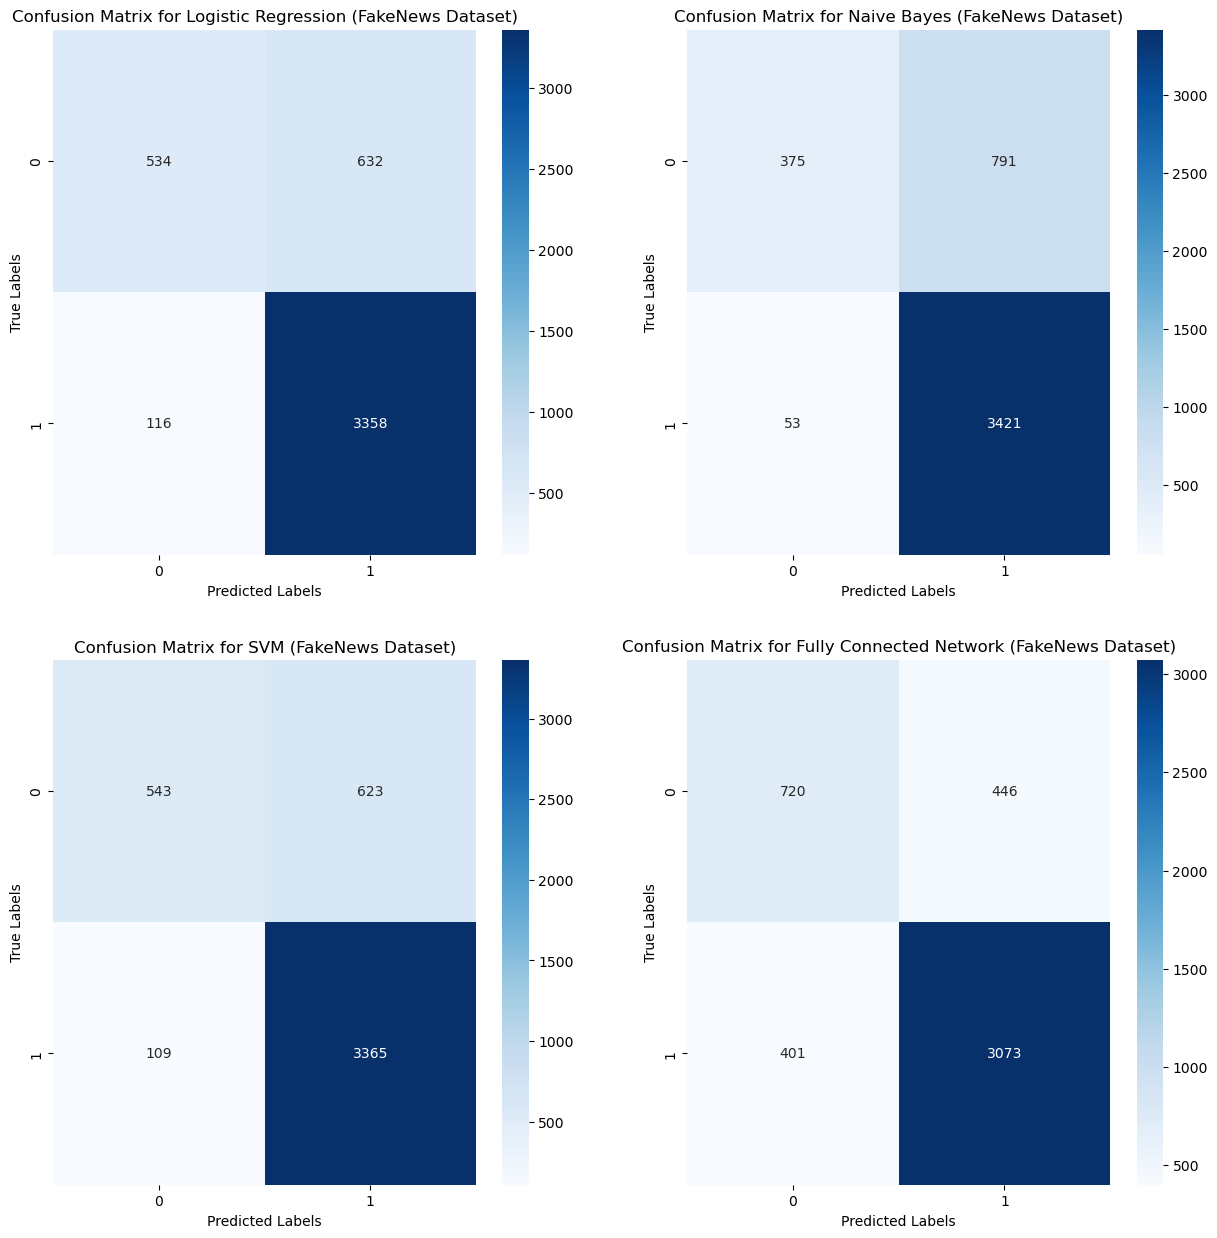

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

cm = confusion_matrix(y_test_fake, y_pred_lr1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[0][0])
axes[0][0].set_xlabel("Predicted Labels")
axes[0][0].set_ylabel("True Labels")
axes[0][0].set_title("Confusion Matrix for Logistic Regression (FakeNews Dataset)")

cm = confusion_matrix(y_test_fake, y_pred_nb1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[0][1])
axes[0][1].set_xlabel("Predicted Labels")
axes[0][1].set_ylabel("True Labels")
axes[0][1].set_title("Confusion Matrix for Naive Bayes (FakeNews Dataset)")

cm = confusion_matrix(y_test_fake, y_pred_svm1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[1][0])
axes[1][0].set_xlabel("Predicted Labels")
axes[1][0].set_ylabel("True Labels")
axes[1][0].set_title("Confusion Matrix for SVM (FakeNews Dataset)")

cm = confusion_matrix(y_test_fake, y_pred_fc1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[1][1])
axes[1][1].set_xlabel("Predicted Labels")
axes[1][1].set_ylabel("True Labels")
axes[1][1].set_title("Confusion Matrix for Fully Connected Network (FakeNews Dataset)")
plt.show()

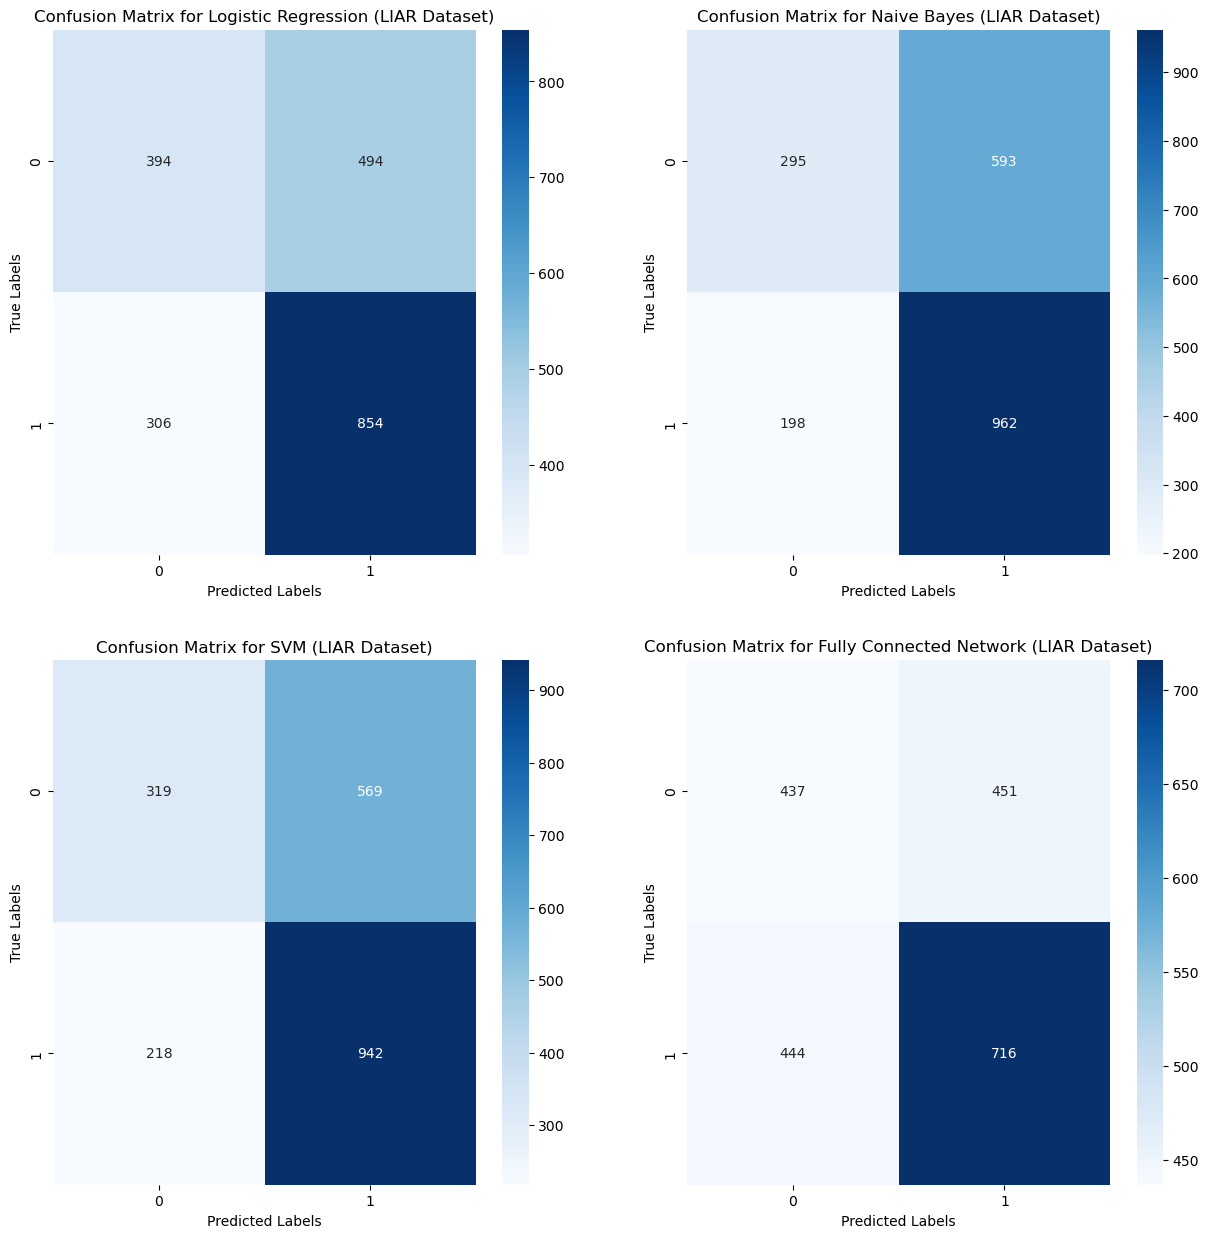

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

cm = confusion_matrix(y_test_liar, y_pred_lr2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[0][0])
axes[0][0].set_xlabel("Predicted Labels")
axes[0][0].set_ylabel("True Labels")
axes[0][0].set_title("Confusion Matrix for Logistic Regression (LIAR Dataset)")

cm = confusion_matrix(y_test_liar, y_pred_nb2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[0][1])
axes[0][1].set_xlabel("Predicted Labels")
axes[0][1].set_ylabel("True Labels")
axes[0][1].set_title("Confusion Matrix for Naive Bayes (LIAR Dataset)")

cm = confusion_matrix(y_test_liar, y_pred_svm2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[1][0])
axes[1][0].set_xlabel("Predicted Labels")
axes[1][0].set_ylabel("True Labels")
axes[1][0].set_title("Confusion Matrix for SVM (LIAR Dataset)")

cm = confusion_matrix(y_test_liar, y_pred_fc2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1],ax=axes[1][1])
axes[1][1].set_xlabel("Predicted Labels")
axes[1][1].set_ylabel("True Labels")
axes[1][1].set_title("Confusion Matrix for Fully Connected Network (LIAR Dataset)")
plt.show()